In [18]:
from sklearn import svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import os
from PIL import Image

from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report,

from keras import backend as K

import tensorflow as tf
from tensorflow import reshape
from tensorflow.keras import metrics
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from imblearn.over_sampling import RandomOverSampler

In [10]:
# unzip spectrogram data
os.system("7z x spectrogram.7z")
os.system("7z x cwt.7z")

512

In [56]:
# preprocessing
def normalize_column(df, column_name, min_val, max_val):
    df[column_name + '_normalized'] = (df[column_name].clip(lower=min_val) - min_val) / (max_val - min_val)
    return df

def check_hypoxia_conditions(row):
    # Check conditions for each column
    if (
        row['pH'] < 7.15
        or row['BDecf'] > 10
        or row['pCO2'] > 10
        or row['BE'] < -10
        or row['Apgar5'] < 7
        ):
        return 1
    else:
        return 0

normal_columns = {
    'pH': (7, 7.4),
    'BDecf': (-2, 20),
    'pCO2': (3, 10),
    'BE': (2, 10)
}

labels_df = pd.read_csv('outcomes.csv')
df = labels_df.dropna()

filenames = df["filename"]
df['hypoxia'] = df.apply(check_hypoxia_conditions, axis=1)
df['hypoxia'].value_counts()


# for column_name in normal_columns:
#     df = normalize_column(df, column_name, min_val, max_val)
# df['sum_normalized'] = df[[column + '_normalized' for column in columns_to_normalize]].sum(axis=1


#labels = labels_df[["Apgar5unmapped"]]-1
# labels = labels_df[["Apgar1", "Apgar5"]].mean(axis=1)
# labels = labels.apply(lambda x: min(2, max(0, round(x))))

<ipython-input-56-5f29be0a99c2>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hypoxia'] = df.apply(check_hypoxia_conditions, axis=1)


0    426
1    108
Name: hypoxia, dtype: int64

Column 'pH': Min = 6.87, Max = 7.47, Mean = 7.233838951310862, Std = 0.09875424943774638


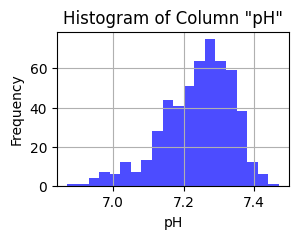

Column 'BDecf': Min = -3.4, Max = 26.11, Mean = 4.558670411985019, Std = 3.4768450245249367


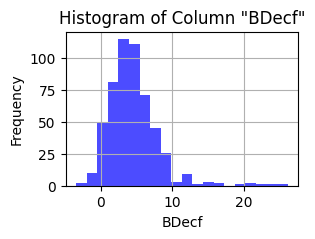

Column 'pCO2': Min = 0.7, Max = 12.3, Mean = 7.0531835205992515, Std = 1.5430711731580902


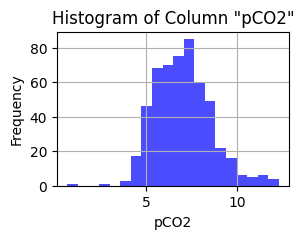

Column 'BE': Min = -26.8, Max = -0.2, Mean = -6.332209737827714, Std = 3.744656228196677


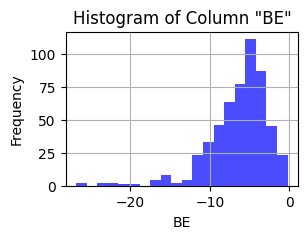

In [55]:
#@markdown # View data

for column in normal_columns:
    min_val = df[column].min()
    max_val = df[column].max()
    mean_val = df[column].mean()
    std_val = df[column].std()

    print(f"Column '{column}': Min = {min_val}, Max = {max_val}, Mean = {mean_val}, Std = {std_val}")
    plt.figure(figsize=(3, 2))
    plt.hist(df[column], bins=20, color='blue', alpha=0.7)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Column "{column}"')
    plt.grid(True)
    plt.show()

In [57]:
# generate test train set
num_classes = 2
labels = df['hypoxia']
labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

images = []
for filename in filenames:
    try:
        path = os.path.join(os.getcwd(), 'spectrogram', filename)
        img = tf.keras.preprocessing.image.load_img(path, target_size=(150, 150))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
    except Exception as e:
        print(f"Error loading image {filename}: {e}")

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.25, random_state=42)

train_images = tf.convert_to_tensor(train_images)
test_images = tf.convert_to_tensor(test_images)

[1. 0.]


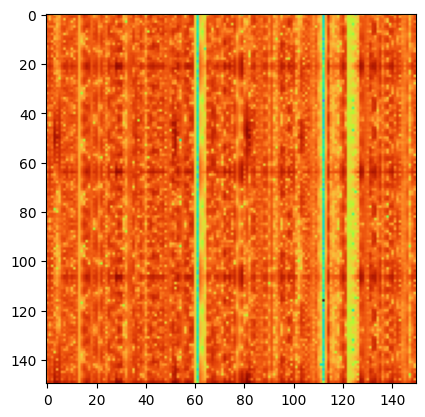

In [4]:
test = 7
image_to_display = train_images[7].numpy()
plt.imshow(image_to_display.astype(int))
print(train_labels[7])

In [31]:
# check dataset balance
np.sum(train_labels, axis=0)

array([329.,  71.], dtype=float32)

In [58]:
# DCNN

np.random.seed(42)
tf.random.set_seed(42)

train_images_resampled = train_images
train_labels_resampled = train_labels

# oversampler = RandomOverSampler()
# train_images_resampled = reshape(train_images_resampled, (train_images_resampled.shape[0], -1))
# train_images_resampled, train_labels_resampled = oversampler.fit_resample(train_images_resampled, train_labels.argmax(axis=1))
# train_images_resampled = train_images_resampled.reshape(train_images_resampled.shape[0], 150, 150, 3)
# train_labels_resampled = to_categorical(train_labels_resampled, num_classes=2)

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(train_labels_resampled.argmax(axis=1)),
    y = train_labels_resampled.argmax(axis=1)
    )
class_weight_dict = dict(enumerate(class_weights))

model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(),
        metrics.Recall(),
        metrics.F1Score(),
      ],
    )

model.fit(
    train_images_resampled,
    train_labels_resampled,
    epochs=50,
    batch_size=32,
    validation_split=0.25,
    verbose=1,
    class_weight=class_weight_dict
    )
model.evaluate(test_images, test_labels, verbose=2)


Epoch 1/50
10/10 [==============================] - 3s 188ms/step - loss: 815.3723 - accuracy: 0.5267 - precision_19: 0.5267 - recall_19: 0.5267 - f1_score: 0.4751 - val_loss: 16.5691 - val_accuracy: 0.8000 - val_precision_19: 0.8000 - val_recall_19: 0.8000 - val_f1_score: 0.4444
Epoch 2/50
10/10 [==============================] - 0s 37ms/step - loss: 13.6503 - accuracy: 0.4967 - precision_19: 0.4967 - recall_19: 0.4967 - f1_score: 0.4668 - val_loss: 0.7591 - val_accuracy: 0.8000 - val_precision_19: 0.8000 - val_recall_19: 0.8000 - val_f1_score: 0.4444
Epoch 3/50
10/10 [==============================] - 0s 34ms/step - loss: 0.9227 - accuracy: 0.7967 - precision_19: 0.7967 - recall_19: 0.7967 - f1_score: 0.6186 - val_loss: 0.9358 - val_accuracy: 0.6200 - val_precision_19: 0.6200 - val_recall_19: 0.6200 - val_f1_score: 0.4933
Epoch 4/50
10/10 [==============================] - 0s 33ms/step - loss: 0.9489 - accuracy: 0.6233 - precision_19: 0.6233 - recall_19: 0.6233 - f1_score: 0.5165 - v

[1.2078510522842407,
 0.6791045069694519,
 0.6791045069694519,
 0.6791045069694519,
 array([0.79620856, 0.24561404], dtype=float32)]

In [59]:
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

class_counts = np.bincount(predicted_classes)
accuracy = np.mean(predicted_classes == true_classes)

print("Count of guesses in each class:")
for cls, count in enumerate(class_counts):
    print(f"Class {cls}: {count} guesses")

print(f"\nAccuracy: {accuracy:.4f}")

# print(predictions)

5/5 [==============================] - 0s 8ms/step
Count of guesses in each class:
Class 0: 104 guesses
Class 1: 30 guesses

Accuracy: 0.6791


In [ ]:
# model = Sequential([
#     layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.Conv2D(256, (3, 3), activation='relu'),

#     layers.Flatten(),

#     layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
#     layers.Dropout(0.5),

#     layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
#     layers.Dropout(0.5),

#     layers.Dense(2, activation='softmax')
# ])
